**Steps**
- bring in target from binary_categories table for policy change practices ONLY FOR sites in OPP-115
- bring in features from segment table ONLY FOR sites in OPP-115
- check for length!
- set up text processing functions
- set up BOW >> TFIDF >> Naive Bayes pipeline
- train-test-split data
- fit, predict, check classification
- wash, rinse, repeat
- pickle out trained model

In [1]:
#Basic imports
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import *
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#Notifications
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [3]:
#Database imports and credentials
import psycopg2

In [4]:
#Establish database connection
dbname = 'beforeiagree_db'
username = 'peterostendorp'

#Create engine
con = psycopg2.connect(database = dbname, user = username)

## Segment-level model

In [5]:
sql = """
SELECT "Policy UID", segment_id, policy_change FROM binary_segment_categories
WHERE binary_segment_categories."Policy UID" IN
(SELECT "Policy UID" FROM sites
WHERE sites."In 115 Set?" IS TRUE);
"""

targets_segments = pd.read_sql_query(sql,con)

In [6]:
targets_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6469 entries, 0 to 6468
Data columns (total 3 columns):
Policy UID       6469 non-null int64
segment_id       6469 non-null int64
policy_change    6469 non-null int64
dtypes: int64(3)
memory usage: 151.7 KB


In [7]:
targets_segments['policy_change'].value_counts()

0    6258
1     211
Name: policy_change, dtype: int64

In [8]:
targets_segments['policy_change'].value_counts()[1]/targets_segments['policy_change'].count()

0.032617096923790383

Note: only about 3% of segments in these documents pertain to this topic.

In [9]:
targets_segments.groupby('Policy UID').sum()['policy_change'].value_counts()

1     47
0     30
2     26
3      3
12     2
6      2
24     1
18     1
13     1
7      1
5      1
Name: policy_change, dtype: int64

Most documents **do** mention data retention, so predicting at the policy level could be an option.

In [6]:
#Get segments associated with policies in the OPP-115 corpus
sql = """
SELECT * FROM segments_processed
WHERE "Policy UID" IN 
(SELECT "Policy UID" FROM sites
WHERE "In 115 Set?" = TRUE)
"""

segments = pd.read_sql_query(sql,con)

In [11]:
print(segments.shape)
segments.head()

(6469, 4)


,index,Policy UID,segment_id,segments
0,0,20,0,privaci polici effect januari 1 2015 atlant mo...
1,1,20,1,privaci polici appli site maintain compani org...
2,2,20,2,visit site accept practic describ privaci poli...
3,3,20,3,inform collect collect two basic type inform c...
4,4,20,4,person identifi inform general matter brows si...


### Feature engineering for segment pre-processing

Do **NOT** have to perform this step unless pulling from `segments` table.

In [7]:
#Initial text-processing function for segments... not much needed here.
#Set up our initial text cleaning function
def text_process_policy(doc):
    """
    1. remove HTML tags
    2. remove punctuation
    3. remove stopwords
    4. stemming
    5. remove '|||' inserted into corpus documents only
    
    Returns a string of the processed doc.
    """
    sn = SnowballStemmer(language='english')
    
    lst = [word for word in doc.split() if re.search(r'\<.*\>',word) is None]
    lst = ' '.join(lst)
    lst = [char for char in lst if char not in string.punctuation]
    lst = ''.join(lst)    
    lst = [word.lower() for word in lst.split() if word.lower() not in stopwords.words('english')]
    lst = [sn.stem(word) for word in lst]
    lst = [word for word in lst if word.replace('|||','')]
    return ' '.join(lst)

Do **NOT** have to perform this step unless pulling from `segments` table.

In [8]:
#Process the segments here
segments['segments'] = segments['segments'].apply(text_process_policy)

In [12]:
#Print a few of them at random
for i in range(0,10):
    print(segments['segments'].iloc[np.random.randint(0,6000)])

use cooki enhanc brows shop experi site cooki small file record place comput hard drive collect inform activ site inform captur make possibl us speed navig keep track item shop cart provid custom tailor content
e parent abl consent use child person identifi inform without consent websit disclosur child person identifi inform third parti share person identifi inform children age 13 third parti servic partner help us provid lyndacom servic
7 web site servic respons practic employ websit servic link servic includ inform content contain within pleas rememb use link go servic anoth websit servic privaci polici appli thirdparti websit servic brows interact thirdparti websit servic includ link websit subject third parti rule polici addit agre respons control thirdparti author access user content use thirdparti websit servic allow access user content risk
protect inform maintain physic electron safeguard polici procedur intend prevent unauthor access consum inform
easypay enrol alreadi ahfc cu

In [13]:
from nltk.probability import FreqDist

In [7]:
policy_change_segments = segments.merge(targets_segments,on=['Policy UID','segment_id']).drop_duplicates()
words = ' '.join(list(policy_change_segments[policy_change_segments['policy_change']==1]['segments'])).split()

In [15]:
f = FreqDist(words)
df2 = pd.DataFrame(f.most_common(100),columns=['Word','Frequency']).set_index('Word')

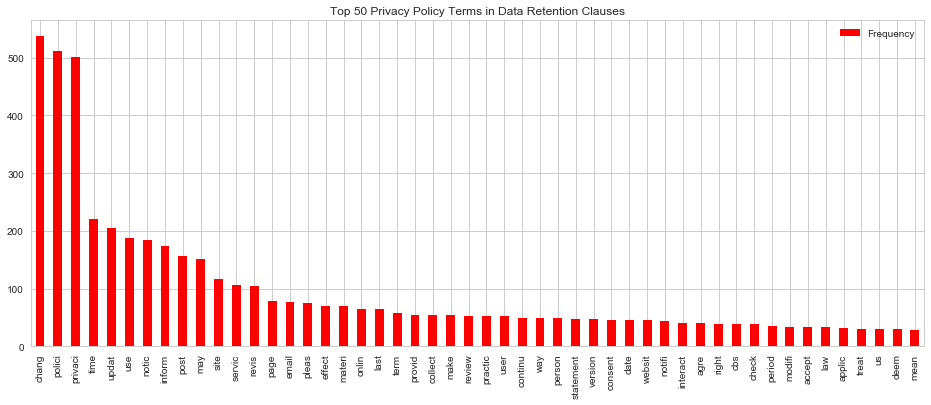

In [16]:
#Word frequency stuff
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
n_words = 50
sns.set_style('whitegrid')
df2.iloc[:n_words].plot.bar(figsize=(16,6),color='red')
plt.title('Top %s Privacy Policy Terms in Data Retention Clauses' % n_words)
plt.xlabel('')

In [8]:
#Split data using 30%/70% split, random seed is my birthday
segments_train, segments_test, targets_train, targets_test = train_test_split(policy_change_segments['segments'], 
    policy_change_segments['policy_change'], test_size=0.3, random_state=84)

### Naive Bayes approach

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, cross_val_score

In [10]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops a Naive Bayes classifier.
policy_change_NB_segment = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [11]:
#Build out ROC curve for variety of n_classifiers
policy_change_NB_segment.fit(segments_train, targets_train)
targets_prob = policy_change_NB_segment.predict_proba(segments_test)
preds = policy_change_NB_segment.predict(segments_test)
fpr, tpr, thresholds = roc_curve(targets_test, targets_prob[:,1])
roc_auc = auc(fpr,tpr)

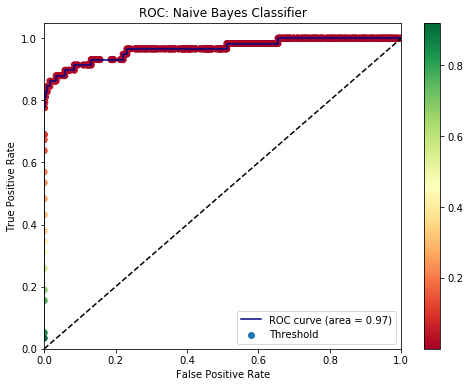

In [12]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresholds, cmap='RdYlGn', label='Threshold')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Naive Bayes Classifier')
plt.legend(loc="lower right")

## Current threshold is 0.05

In [21]:
best = 0.05
policy_change_NB_final = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])
policy_change_NB_final.fit(segments_train,targets_train)
preds = policy_change_NB_final.predict_proba(segments_test)[:,1]
preds[preds >= best] = 1
preds[preds < best] = 0

In [22]:
#Quick diagnostics
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[1874    9]
 [  10   48]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1883
          1       0.84      0.83      0.83        58

avg / total       0.99      0.99      0.99      1941



In [23]:
#Pickle it out
import pickle
with open('../pickles/policy_change_NB_segment.pkl','wb') as file:
    pickle.dump(policy_change_NB_final,file)

### Random Forest Classifier

**Observations**
- more estimators don't seem to help much
- feature pre-processing seems to be the bigger factor

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
#New pipeline
data_retention_RF_segment = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier(class_weight='balanced'))
])

In [59]:
#Do a k-fold cross validation and get AUC for ROC curve for each
cv = KFold(n_splits=5,random_state=84)
scoring='roc_auc'

results = cross_val_score(data_retention_RF_segment,segments_train,targets_train,cv=cv,scoring=scoring)
print('AUC: min %0.3f, mean %0.3f, max %0.3f' % (results.min(), results.mean(), results.max()))

AUC: min 0.486, mean 0.517, max 0.544


In [51]:
#Build out ROC curve for variety of n_classifiers
n_estimators = [10,50,100]
fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

for n in n_estimators:
#     data_encryption_RF_segment = Pipeline([
#         ('bow',CountVectorizer()),
#         ('tfidf',TfidfTransformer()),
#         ('classifier',RandomForestClassifier(class_weight='balanced',n_estimators=n))
#     ])
    params = {'classifier__n_estimators': n}
    data_retention_RF_segment.set_params(**params)
    data_retention_RF_segment.fit(segments_train, targets_train)
    targets_prob = data_retention_RF_segment.predict_proba(segments_test)
    #preds = data_encryption_RF_segment.predict(segments_test)
    fpr[n], tpr[n], thresholds[n] = roc_curve(targets_test, targets_prob[:,1])
    roc_auc[n] = auc(fpr[n],tpr[n])

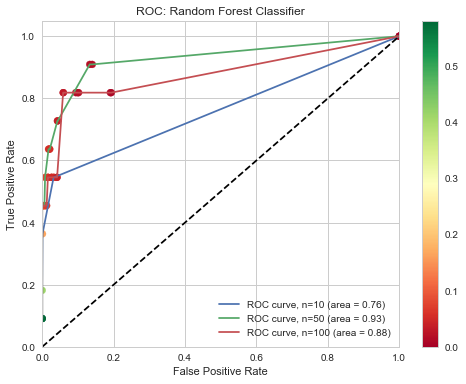

In [37]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for n in n_estimators:
    plt.plot(fpr[n], tpr[n], label='ROC curve, n=%s (area = %0.2f)' % (n,roc_auc[n]))
    plt.scatter(fpr[n], tpr[n], c=thresholds[n], cmap='RdYlGn')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier')
plt.legend(loc="lower right")

In [39]:
thresholds[50]

array([ 0.62      ,  0.26      ,  0.24      ,  0.14      ,  0.12      ,
        0.1       ,  0.08      ,  0.06      ,  0.05958519,  0.05950536,
        0.04      ,  0.03983421,  0.02      ,  0.01983421,  0.        ])

In [52]:
#Use 50 estimators with weighting set based on play w/values from ROC curve
best = 0.5
data_retention_RF_final = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier(n_estimators=50,class_weight={0:1-best,1:best}))
])
data_retention_RF_final.fit(segments_train,targets_train)
preds = data_retention_RF_final.predict(segments_test)

In [53]:
#Quick diagnostics
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[1127    0]
 [  10    1]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1127
          1       1.00      0.09      0.17        11

avg / total       0.99      0.99      0.99      1138



In [54]:
import pickle
with open('../pickles/data_retention_RF_segment.pkl','wb') as file:
    pickle.dump(data_retention_RF_final,file)

## Policy-level model
### Multinomial Naive Bayes

In [193]:
#Select category targets
sql = """
SELECT "Policy UID",data_security FROM binary_policy_categories
WHERE "Policy UID" IN 
(SELECT "Policy UID" FROM sites
WHERE "In 115 Set?" = TRUE)
"""

targets_policies = pd.read_sql_query(sql,con)

In [194]:
targets_policies.head()

,Policy UID,data_security
0,20,1
1,21,1
2,26,1
3,32,1
4,33,1


In [195]:
#Select original policies as features
sql = """
SELECT "Policy UID", policy_text FROM sites
WHERE sites."In 115 Set?" = TRUE
"""

policies = pd.read_sql_query(sql,con)

In [196]:
policies.head()

,Policy UID,policy_text
0,20,<strong> Privacy Policy </strong> <br> <br> <s...
1,21,"IMDb Privacy Notice <br> <br>|||Last Updated, ..."
2,26,<strong> Privacy Policy </strong> <br> <br> La...
3,32,Vox Media Privacy Policy <br> <br>|||<strong> ...
4,33,Full Privacy Policy <br> <br> Last updated: 14...


In [197]:
#Split data using 30%/70% split, random seed is my birthday
policies_train, policies_test, targets_train, targets_test = train_test_split(policies['policy_text'], 
    targets_policies['data_security'], test_size=0.3, random_state=84)

In [198]:
policies_train = policies_train.map(text_process_policy)
policies_test = policies_test.map(text_process_policy)

In [199]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops a Naive Bayes classifier.
data_encryption_NB_policy = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [202]:
#Now fit/train the model
data_encryption_NB_policy.fit(policies_train,targets_train)
targets_prob = data_encryption_NB_policy.predict_proba(policies_test)
preds = data_encryption_NB_policy.predict(policies_test)
fpr, tpr, thresh = roc_curve(targets_test, targets_prob[:,1])
roc_auc = auc(fpr,tpr)

In [203]:
thresh

array([ 0.97745218,  0.94137656,  0.93938354,  0.93771542,  0.9357203 ,
        0.89941673,  0.88990142,  0.81776601])

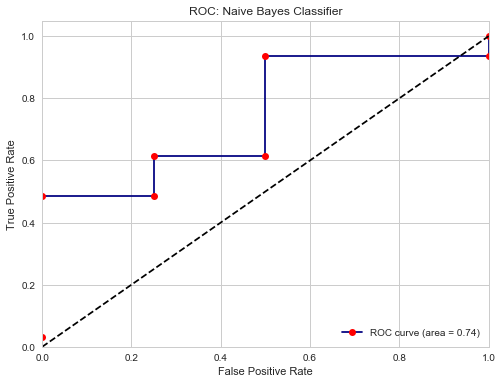

In [204]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc,
        marker='o',markerfacecolor='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Naive Bayes Classifier')
plt.legend(loc="lower right")

Note: optimal performance appears to occur at about the 6th point.

In [210]:
#Set the final model and re-predict
opt = thresh[3] #The 6th point
data_encryption_NB_policy_final = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB(class_prior=[1-opt,opt]))
])
data_encryption_NB_policy_final.fit(policies_train,targets_train)
preds = data_encryption_NB_policy_final.predict(policies_test)

In [211]:
#Report
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[ 0  4]
 [ 0 31]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.89      1.00      0.94        31

avg / total       0.78      0.89      0.83        35



/Users/peterostendorp/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [213]:
#Pickle out the model
import pickle
with open('../pickles/data_encryption_NB_policy.pkl', 'wb') as file:
    pickle.dump(data_encryption_NB_policy_final,file)

### Adaptive boosting

In [138]:
from sklearn.ensemble import AdaBoostClassifier

**TO DO**
- consider different tokenizer
- bigrams?
- pass in legal dictionary

In [139]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops an AdaBoost classifier with 100 weak learners.
data_encryption_ADA_policy = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',AdaBoostClassifier())
])

In [141]:
#Now fit/train the model
#Build out ROC curve for variety of n_classifiers
n_estimators = [10,50,100]
fpr = {}
tpr = {}
roc_auc = {}

for n in n_estimators:
    params = {'classifier__n_estimators': n}
    data_encryption_ADA_policy.set_params(**params)
    data_encryption_ADA_policy.fit(policies_train, targets_train)
    targets_prob = data_encryption_ADA_policy.predict_proba(policies_test)
    #preds = data_encryption_RF_segment.predict(segments_test)
    fpr[n], tpr[n], __ = roc_curve(targets_test, targets_prob[:,1])
    roc_auc[n] = auc(fpr[n],tpr[n])

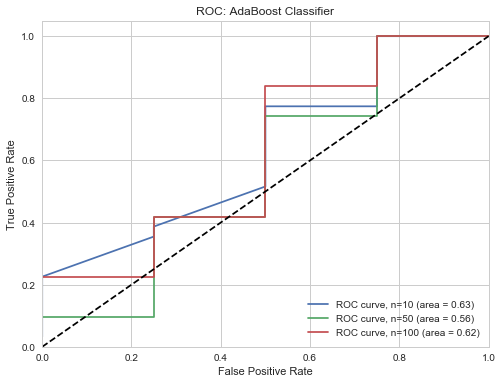

In [142]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for n in n_estimators:
    plt.plot(fpr[n], tpr[n], label='ROC curve, n=%s (area = %0.2f)' % (n,roc_auc[n]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: AdaBoost Classifier')
plt.legend(loc="lower right")

In [143]:
#Report
preds = data_encryption_ADA_policy.predict(policies_test)
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[ 2  2]
 [ 6 25]]
             precision    recall  f1-score   support

          0       0.25      0.50      0.33         4
          1       0.93      0.81      0.86        31

avg / total       0.85      0.77      0.80        35



In [86]:
import pickle

In [87]:
with open('../pickles/data_encryption_ADA_policy.pkl', 'wb') as file:
    pickle.dump(data_encryption_ADA_policy,file)

## Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops an AdaBoost classifier with 100 weak learners.
data_encryption_RF_policy = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier(class_weight='balanced'))
])

In [158]:
#Now fit/train the model
#Build out ROC curve for variety of n_classifiers
n_estimators = [10,50,100,200,300]
fpr = {}
tpr = {}
roc_auc = {}

for n in n_estimators:
    params = {'classifier__n_estimators': n}
    data_encryption_RF_policy.set_params(**params)
    data_encryption_RF_policy.fit(policies_train, targets_train)
    targets_prob = data_encryption_RF_policy.predict_proba(policies_test)
    #preds = data_encryption_RF_segment.predict(segments_test)
    fpr[n], tpr[n], __ = roc_curve(targets_test, targets_prob[:,1])
    roc_auc[n] = auc(fpr[n],tpr[n])

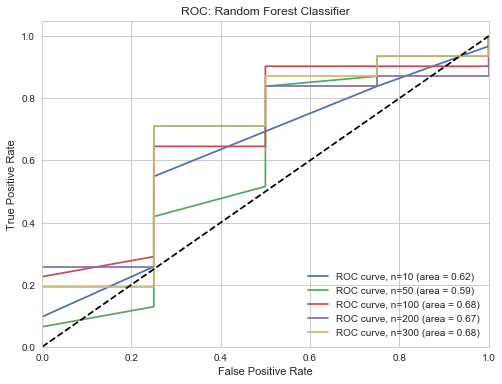

In [159]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for n in n_estimators:
    plt.plot(fpr[n], tpr[n], label='ROC curve, n=%s (area = %0.2f)' % (n,roc_auc[n]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier')
plt.legend(loc="lower right")

In [160]:
#Predict
preds = data_encryption_RF_policy.predict(policies_test)

In [161]:
#Report
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[ 0  4]
 [ 2 29]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.88      0.94      0.91        31

avg / total       0.78      0.83      0.80        35



In [94]:
# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../pickles/data_encryption_RF_policy.pkl', 'wb') as file:
    pickle.dump(data_encryption_RF_policy,file)